In [1]:
import imageio
from skimage.transform import resize
import torch
from tqdm import tqdm
from animate import normalize_kp
from demo import load_checkpoints
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import img_as_ubyte
import cv2
import os

from cv2 import VideoWriter, VideoWriter_fourcc

d:\python projects\projects\deep learning\gans\first order motion model for image animation\real_time_image_animation\env\lib\site-packages\dask\config.py:129: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\python projects\Projects\Deep Learning\GANS\First Order Motion Model for Image Animation\Real_Time_Image_Animation\demo.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\shubham pawara\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\shubham pawara\anaconda3\lib\runpy.py", line 85, in _r

D:\python projects\Projects\Deep Learning\GANS\First Order Motion Model for Image Animation\Real_Time_Image_Animation\demo.py:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


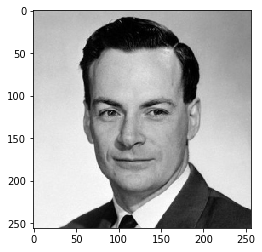

In [3]:
source_image = imageio.imread('Inputs/feynman.jpeg')
source_image = resize(source_image,(256,256))[..., :3]
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', checkpoint_path='checkpoints/vox-cpk.pth.tar')
plt.imshow(source_image)
plt.show()

In [9]:
if not os.path.exists('output'):
    os.mkdir('output')

In [14]:
relative=True
adapt_movement_scale=True
cpu=False
# face_cascade = cv2.CascadeClassifier('cascades/data/haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out1 = cv2.VideoWriter('output/test.avi', fourcc, 12, (256*3 , 256), True)

cv2_source = cv2.cvtColor(source_image.astype('float32'),cv2.COLOR_BGR2RGB)
with torch.no_grad() :
    predictions = []
    source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
    if not cpu:
        source = source.cuda()
    kp_source = kp_detector(source)
    count = 0
    while(True):
        ims = [source_image]
        ret, frame = cap.read()
        
#         out1.write(frame)
        frame = cv2.flip(frame,1)
        
#         faces = face_cascade.detectMultiScale(frame, scaleFactor=1.5, minNeighbors=5)
#         if len(faces) != 0:
#             x,y,w,h = faces[0]
#             x = x-70
#             y = y-70
#             w = w+140
#             h = h+140
#             print(x,y,w,h,faces[0])
#         else:
        x = 143
        y = 87
        w = 322
        h = 322 

        frame = frame[y:y+h,x:x+w]
#         test = img_as_ubyte(frame)
#         out1.write(test)
        frame1 = resize(frame,(256,256))[..., :3]
#         cv2.imwrite('output/test'+str(count)+'.jpg',img_as_ubyte(frame1))
        if count == 0:
            source_image1 = frame1
            source1 = torch.tensor(source_image1[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
            kp_driving_initial = kp_detector(source1)
        
        frame_test = torch.tensor(frame1[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)

        driving_frame = frame_test
        if not cpu:
            driving_frame = driving_frame.cuda()
        kp_driving = kp_detector(driving_frame)
        kp_norm = normalize_kp(kp_source=kp_source,
                               kp_driving=kp_driving,
                               kp_driving_initial=kp_driving_initial, 
                               use_relative_movement=relative,
                               use_relative_jacobian=relative, 
                               adapt_movement_scale=adapt_movement_scale)
        out = generator(source, kp_source=kp_source, kp_driving=kp_norm)
        predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
        im = np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0]
        im = cv2.cvtColor(im,cv2.COLOR_RGB2BGR)
        joinedFrame = np.concatenate((cv2_source,im,frame1),axis=1)
        
        cv2.imshow('Test',joinedFrame)
        out1.write(img_as_ubyte(joinedFrame))
        count += 1
        if cv2.waitKey(20) & 0xFF == ord('q'):
            break
        
    cap.release()
    out1.release()
    cv2.destroyAllWindows()